In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


##Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
states_df = pd.read_csv('df_states_only (1).csv')
admissions_df = pd.read_csv('weekly_avg_admissions_from_daily (1).csv')
display(states_df.head())
display(admissions_df.head())

,states,number_hospitals_reporting_today,total_hospitals,admissions_all_covid_confirmed,admissions_70_covid_confirmed,admissions_30_49_covid_confirmed,admissions_50_69_covid_confirmed,admissions_18_29_covid_confirmed,average_admissions_all_covid_confirmed,average_admissions_18_29_covid_confirmed,...,absolute_change_average_percent_staff_adult_icu_beds_occupied,absolute_change_average_percent_staff_pediatric_icu_beds_occupied,year_month,month,covid_admissions_young,covid_admissions_middle_aged,covid_admissions_geriatric,young,middle_aged,elderly
0,AZ,55.0,95.0,95.0,26.0,16.0,35.0,9.0,125.714286,8.571429,...,-4.678492,3.774523,2020-08,2020-08,9.0,51.0,26.0,9.0,51.0,26.0
1,AZ,76.0,95.0,124.0,29.0,24.0,34.0,5.0,123.428571,8.714286,...,-3.284308,-0.040802,2020-08,2020-08,5.0,58.0,29.0,5.0,58.0,29.0
2,AZ,82.0,95.0,100.0,26.0,21.0,28.0,8.0,123.428571,9.285714,...,-2.437162,-8.305584,2020-08,2020-08,8.0,49.0,26.0,8.0,49.0,26.0
3,AZ,81.0,95.0,121.0,32.0,23.0,32.0,13.0,120.571429,9.571429,...,-1.014152,-5.207254,2020-08,2020-08,13.0,55.0,32.0,13.0,55.0,32.0
4,AZ,84.0,95.0,120.0,27.0,28.0,35.0,8.0,118.285714,9.571429,...,-0.110215,-5.779696,2020-08,2020-08,8.0,63.0,27.0,8.0,63.0,27.0


,collection_date,average_admissions_all_covid_confirmed
0,2020-08-02,101.007003
1,2020-08-09,93.713085
2,2020-08-16,84.008003
3,2020-08-23,83.309724
4,2020-08-30,77.724690


####***XGBOOST regressor is somewhat robust to outliers, since it utilizes a tree-based algorithm which split data based on feature values rather than weighted combinations we shall log-transform the data instead of performing scaling.***
***Log-transformation, essentially compresses the large values and expands the small values. This creates a more balanced distribution that allows the tree-based algorithm to make more nuanced splits across the entire range of your data, i.e the respiratory virus admissions data across different times and different seasons,might have many days with low admissions and occasional spikes during outbreaks. This creates a distribution where most values cluster near zero with some very large values. The data, therefore might seem highly skewed***      

In [4]:
#Log transform
num_cols_states = states_df.select_dtypes(include=['number']).columns.tolist()
num_cols_states = states_df.select_dtypes(include=['number']).columns.tolist()
num_cols_admissions = admissions_df.select_dtypes(include=['number']).columns.tolist()
# Apply log1p transform
log_states = states_df.copy()
log_states[num_cols_states] = np.log1p(log_states[num_cols_states])
log_admin = admissions_df.copy()
log_admin[num_cols_admissions] = np.log1p(log_admin[num_cols_admissions])

####****Creating functions for a pipeline to minimize data leaks****

In [5]:
def temporal_features_for_covid_admissions(admissions_df, target_col='average_admissions_all_covid_confirmed', lookback_periods=8):
    """
    Creating temporal features specifically for your COVID admissions data
    target_col: the admissions column we want to predict
    lookback_periods: how many weeks back to look (8 weeks = ~2 months of context)
    """

    data = admissions_df.copy()

    print("Examining date column format...")
    print(f"Sample dates: {data['collection_date'].head(3).tolist()}")
    print(f"Date column type: {data['collection_date'].dtype}")

    try:
        data['collection_date'] = pd.to_datetime(data['collection_date'])
        print("✓ Date conversion successful with automatic detection")
    except:
        try:
            data['collection_date'] = pd.to_datetime(data['collection_date'], format='%Y-%m-%d')
            print("✓ Date conversion successful with ISO format")
        except:
            data['collection_date'] = pd.to_datetime(data['collection_date'], format='mixed')
            print("✓ Date conversion successful with mixed format parsing")

    # Sorting by date to ensure proper temporal ordering
    data = data.sort_values('collection_date')

    # Reseting index to ensure clean sequential indexing after sorting
    data = data.reset_index(drop=True)

    print(f"Date range: {data['collection_date'].min()} to {data['collection_date'].max()}")
    print(f"Total time periods: {len(data)}")

    # Creating lagged features
    print("Creating lagged features...")
    for i in range(1, lookback_periods + 1):
        data[f'{target_col}_lag_{i}'] = data[target_col].shift(i)

    # Creating rolling statistics to capture trends and patterns
    print("Creating rolling window features...")
    for window in [2, 4, 8]:
        data[f'{target_col}_rolling_mean_{window}'] = data[target_col].rolling(window).mean()
        data[f'{target_col}_rolling_std_{window}'] = data[target_col].rolling(window).std()
        data[f'{target_col}_rolling_min_{window}'] = data[target_col].rolling(window).min()
        data[f'{target_col}_rolling_max_{window}'] = data[target_col].rolling(window).max()

    # Calculating percentage changes to capture growth/decline patterns
    print("Creating change and trend features...")
    data[f'{target_col}_pct_change_1week'] = data[target_col].pct_change(periods=1)
    data[f'{target_col}_pct_change_2week'] = data[target_col].pct_change(periods=2)
    data[f'{target_col}_pct_change_4week'] = data[target_col].pct_change(periods=4)

    # Creating seasonal features from the date
    print("Creating seasonal features...")
    data['week_of_year'] = data['collection_date'].dt.isocalendar().week
    data['month'] = data['collection_date'].dt.month
    data['quarter'] = data['collection_date'].dt.quarter
    data['year'] = data['collection_date'].dt.year

    # Creating cyclical features for seasonality
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    # Remove rows with NaN values created by  transformations
    data_clean = data.dropna()

    print(f"\n📊 Feature Engineering Summary:")
    print(f"Original data shape: {admissions_df.shape}")
    print(f"After temporal features: {data_clean.shape}")
    print(f"New features created: {len([col for col in data_clean.columns if col not in admissions_df.columns])}")
    print(f"Data loss due to lags/rolling: {len(data) - len(data_clean)} rows")

    return data_clean

In [6]:
def aggregate_state_features(states_df):

    # Group by time period (adjust this based on your actual time column)
    # I'm assuming 'year_month' based on your column list
    if 'year_month' in states_df.columns:
        time_col = 'year_month'
    else:
        print("Warning: No clear time column found in states data")
        return states_df

    numeric_cols = states_df.select_dtypes(include=['number']).columns.tolist()

    # Removing identifier columns that shouldn't be aggregated
    exclude_cols = ['states'] if 'states' in numeric_cols else []
    agg_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Create aggregate statistics across all states for each time period
    state_aggregates = states_df.groupby(time_col).agg({
        **{col: ['mean', 'std', 'min', 'max', 'sum'] for col in agg_cols[:10]},
        'states': 'count'
    }).round(4)

    state_aggregates.columns = [f"state_agg_{col[0]}_{col[1]}" if col[1] else f"state_agg_{col[0]}"
                               for col in state_aggregates.columns]

    # Reset index to make time_col a regular column
    state_aggregates = state_aggregates.reset_index()

    return state_aggregates

In [7]:
def complete_temporal_dataset(admissions_df, states_df, target_col='average_admissions_all_covid_confirmed'):
    """
    Creation of the complete dataset combining temporal admissions features with state aggregates
    """
    print("Creating temporal features from admissions data...")
    temporal_features = temporal_features_for_covid_admissions(
        log_admin,
        target_col=target_col,
        lookback_periods=6
    )
    print("Creating aggregate features from states data...")
    state_features = aggregate_state_features(log_states)  # Your log-transformed states data

    # Aligning time periods between datasets

    temporal_features['year_month'] = temporal_features['collection_date'].dt.to_period('M').astype(str)

    #  Merging the datasets
    print("Merging temporal and state features...")
    if 'year_month' in state_features.columns:
        complete_dataset = temporal_features.merge(
            state_features,
            on='year_month',
            how='left'  # Keep all temporal records, add state info where available
        )
        print(f"Successfully merged datasets. Final shape: {complete_dataset.shape}")
    else:
        print("Warning: Could not merge with state data. Using only temporal features.")
        complete_dataset = temporal_features

    return complete_dataset

In [8]:
# Applying the complete pipeline to the datasets
target_column = 'average_admissions_all_covid_confirmed'

# Create the complete temporal dataset
final_modeling_data = complete_temporal_dataset(
    admissions_df=log_admin,
    states_df=log_states,
    target_col=target_column
)

# Preparing features for XGBoost
# Excluding non-feature columns (dates, identifiers, target variable)
feature_cols = [col for col in final_modeling_data.columns
                if col not in ['collection_date', 'year_month', target_column]]

X = final_modeling_data[feature_cols]
y = final_modeling_data[target_column]

print(f"Final dataset ready for modeling:")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Target variable: {target_column}")

Creating temporal features from admissions data...
Examining date column format...
Sample dates: ['2020-08-02', '2020-08-09', '2020-08-16']
Date column type: object
✓ Date conversion successful with automatic detection
Date range: 2020-08-02 00:00:00 to 2024-04-28 00:00:00
Total time periods: 196
Creating lagged features...
Creating rolling window features...
Creating change and trend features...
Creating seasonal features...

📊 Feature Engineering Summary:
Original data shape: (196, 2)
After temporal features: (189, 31)
New features created: 29
Data loss due to lags/rolling: 7 rows
Creating aggregate features from states data...
Merging temporal and state features...
Successfully merged datasets. Final shape: (189, 83)
Final dataset ready for modeling:
Features: 80
Samples: 189
Target variable: average_admissions_all_covid_confirmed


*****Using the normal train-test split might lead to data leakage through temporal relationships i.e we can not train our model using September 2024 data and trying to predict the admissions in January 2024.Moreover, timeseries data contains autocorrelation and temporal dependancies meaning today's events are strongly related with yesterday's events. We will therefore import a TimeSeries split*****

In [9]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error,make_scorer

In [10]:
tscv = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(n_estimators=500,
                         learning_rate=0.05,
                         max_depth=10,
                          gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='reg:squarederror',
                         tree_method='hist',
                         eval_metric=["rmse", "mae", "mape"],
                         random_state=42,
                         verbosity=1)
    model.fit(X_train, y_train)

In [11]:
y_pred = model.predict(X_test)

In [12]:
print(y_pred)

[4.54582   4.5383825 4.40144   4.241274  4.1374564 4.0530896 3.9798436
 3.9455957 3.8313537 3.7442017 3.5141232 3.3303277 3.2544982 3.1105313
 3.093803  2.9338398 2.9540746]


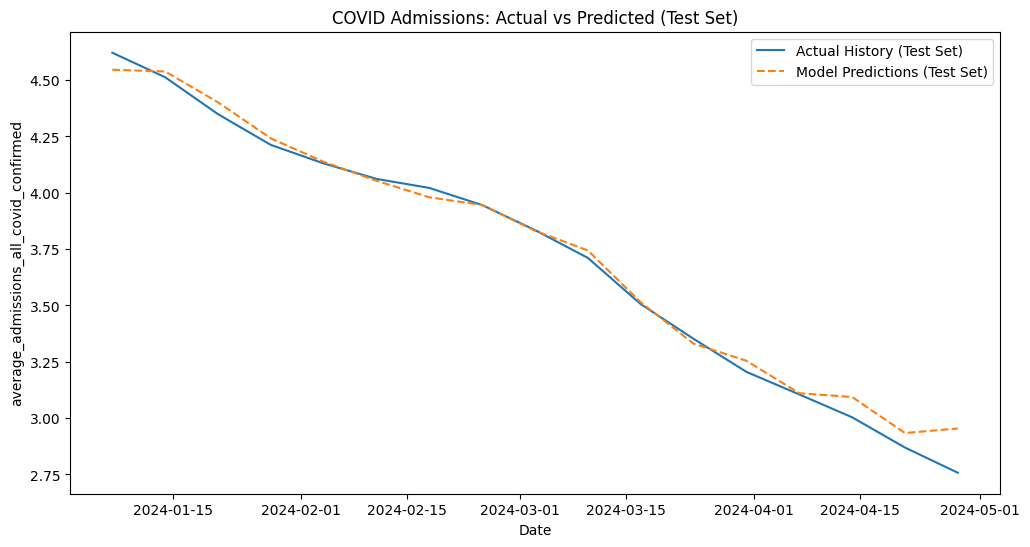

In [13]:
# Plotting the historical actuals vs the model predictions on the *test* set
plt.figure(figsize=(12,6))
# Get the corresponding dates for the test set from the original data
test_dates = final_modeling_data.iloc[test_index]['collection_date']
# Plot the actual historical data from the test set
plt.plot(test_dates, y_test, label='Actual History (Test Set)')
# Plot the model's predictions on the test set
plt.plot(test_dates, y_pred, label='Model Predictions (Test Set)', linestyle='--')
plt.legend()
plt.title('COVID Admissions: Actual vs Predicted (Test Set)') # Add a title for clarity
plt.xlabel('Date') # Add x-axis label
plt.ylabel(target_column) # Add y-axis label based on your target
plt.show()

***From the graph above:
There is a strong downward trend;over the 4-month test window (mid-January to the end of April 2024), average COVID admissions steadily fall while the fit seems excellent.The dashed orange “Model Predictions” line almost hugs the solid blue “Actual” line the whole way.Slight bias at the ends of the graphs shown early in January, the model slightly under-predicts (orange sits just below blue).And late in April, it very marginally over-predicts (orange just above blue).The prediction curve is also slightly smoother than the actuals, suggesting that the model generalizes well (and doesn't overfit), but may under-react to very sudden changes.***



In [14]:
last_date = final_modeling_data['collection_date'].max()

future_dates = pd.date_range(last_date + pd.Timedelta(1, 'W'),
                             periods=30, freq='W')

In [15]:
final_modeling_data.head()

,collection_date,average_admissions_all_covid_confirmed,average_admissions_all_covid_confirmed_lag_1,average_admissions_all_covid_confirmed_lag_2,average_admissions_all_covid_confirmed_lag_3,average_admissions_all_covid_confirmed_lag_4,average_admissions_all_covid_confirmed_lag_5,average_admissions_all_covid_confirmed_lag_6,average_admissions_all_covid_confirmed_rolling_mean_2,average_admissions_all_covid_confirmed_rolling_std_2,...,state_agg_average_admissions_18_29_covid_confirmed_std,state_agg_average_admissions_18_29_covid_confirmed_min,state_agg_average_admissions_18_29_covid_confirmed_max,state_agg_average_admissions_18_29_covid_confirmed_sum,state_agg_average_admissions_40_49_covid_confirmed_mean,state_agg_average_admissions_40_49_covid_confirmed_std,state_agg_average_admissions_40_49_covid_confirmed_min,state_agg_average_admissions_40_49_covid_confirmed_max,state_agg_average_admissions_40_49_covid_confirmed_sum,state_agg_states_count
0,2020-09-20,4.193346,4.247574,4.351916,4.365957,4.434497,4.442745,4.550852,4.220460,0.038345,...,0.7819,0.0,3.8471,1724.2220,1.4096,0.8811,0.0,4.0580,2156.6226,1530
1,2020-09-27,4.183390,4.193346,4.247574,4.351916,4.365957,4.434497,4.442745,4.188368,0.007040,...,0.7819,0.0,3.8471,1724.2220,1.4096,0.8811,0.0,4.0580,2156.6226,1530
2,2020-10-04,4.268720,4.183390,4.193346,4.247574,4.351916,4.365957,4.434497,4.226055,0.060338,...,0.7837,0.0,3.8098,2115.8512,1.7466,0.9187,0.0,4.3874,2761.3817,1581
3,2020-10-11,4.431050,4.268720,4.183390,4.193346,4.247574,4.351916,4.365957,4.349885,0.114785,...,0.7837,0.0,3.8098,2115.8512,1.7466,0.9187,0.0,4.3874,2761.3817,1581
4,2020-10-18,4.548170,4.431050,4.268720,4.183390,4.193346,4.247574,4.351916,4.489610,0.082816,...,0.7837,0.0,3.8098,2115.8512,1.7466,0.9187,0.0,4.3874,2761.3817,1581


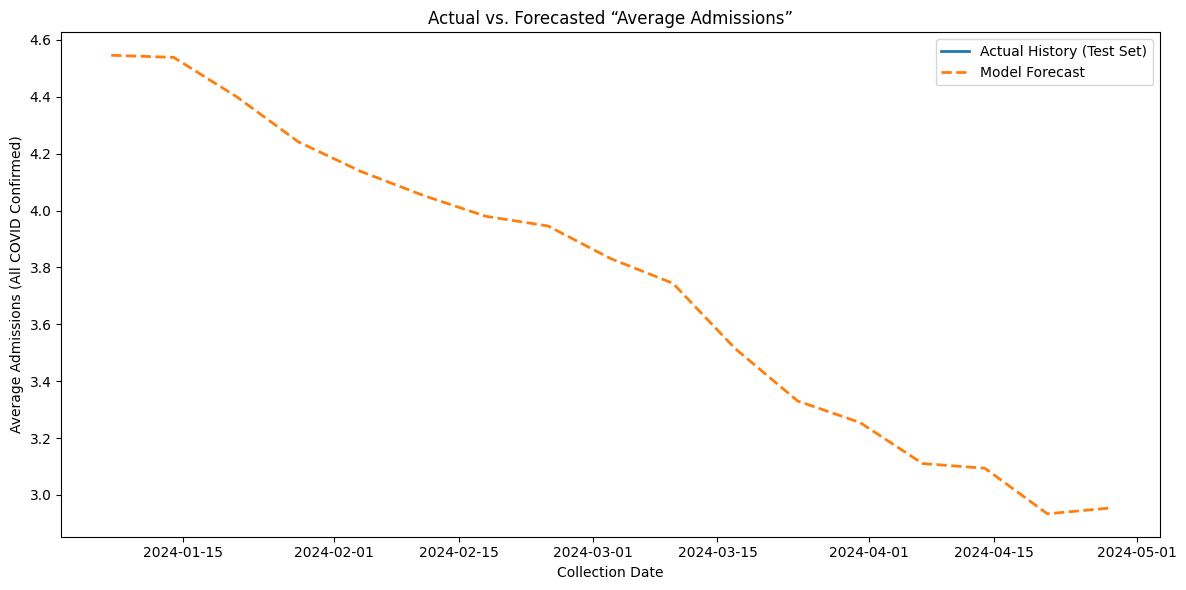

In [16]:
test_dates = pd.to_datetime(final_modeling_data.loc[test_index, 'collection_date'])

# 2) Create Series for neat plotting (optional but handy)
actual_series   = pd.Series(y_test,   index=test_dates, name='Actual')
forecast_series = pd.Series(y_pred,    index=test_dates, name='Forecast')

# 3) Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_series,   label='Actual History (Test Set)', linewidth=2)
plt.plot(forecast_series, label='Model Forecast',          linestyle='--', linewidth=2)
plt.title("Actual vs. Forecasted “Average Admissions”")
plt.xlabel("Collection Date")
plt.ylabel("Average Admissions (All COVID Confirmed)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# RMSE:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE:
mae = mean_absolute_error(y_test, y_pred)

# MAPE:
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2%}")

RMSE: 0.063, MAE: 0.042, MAPE: 1.26%


***The XGBOOST regressor performed fairly well, having a root mean square error of 0.063, meaning the total admissions predicted were off by about 0.063 admissions per hospital give or take. The mean absolute percentage error was 1.26%, meaning our predictions were roughly 1.3% from the actual values.The model however had an error of 0.042 admissions per hospital.***

In [19]:
!pip install prophet
from prophet import Prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 44.8 MB/s eta 0:00:00


####***Data Preparation for Prophet Algorithm***

In [20]:
def prepare_prophet_data(final_modeling_data, target_column='average_admissions_all_covid_confirmed'):
    """
    Prepare data for Prophet forecasting with careful alignment.
    """
    # Create Prophet-compatible dataframe
    prophet_df = pd.DataFrame({
        'ds': pd.to_datetime(final_modeling_data['collection_date']),
        'y': final_modeling_data[target_column]
    })

    # Sort by date and ensure no duplicates
    prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)
    prophet_df = prophet_df.drop_duplicates(subset=['ds'], keep='first')

    # Remove any missing values in target
    prophet_df = prophet_df.dropna(subset=['y'])

    return prophet_df


####***Stable Regressor Selection***

In [21]:
def select_stable_regressors(final_modeling_data, min_coverage=0.9, max_regressors=20):
    """
    Intelligently select the most valuable and stable regressors.
    This helps avoid the curse of dimensionality and regressor forecasting complexity.
    """
    # Get all potential regressor columns
    potential_regressors = []

    # Lag features (most important for time series)
    lag_features = [col for col in final_modeling_data.columns if '_lag_' in col]

    # Rolling statistics (valuable but need careful handling)
    rolling_features = [col for col in final_modeling_data.columns if 'rolling_' in col]

    # State aggregation features (external information)
    state_features = [col for col in final_modeling_data.columns if 'state_agg_' in col]

    all_features = lag_features + rolling_features + state_features

    # Filter by data coverage and select most stable ones
    stable_regressors = []

    for col in all_features:
        if col in final_modeling_data.columns:
            coverage = final_modeling_data[col].notna().sum() / len(final_modeling_data)
            if coverage >= min_coverage:
                # Calculate stability (lower variance in differences indicates more stable)
                stability = 1 / (1 + np.std(np.diff(final_modeling_data[col].dropna())))
                stable_regressors.append((col, coverage, stability))

    # Sort by stability and coverage, prioritize lag features
    stable_regressors.sort(key=lambda x: (
        2.0 if '_lag_' in x[0] else 1.0,  # Prioritize lag features
        x[2],  # Then by stability
        x[1]   # Then by coverage
    ), reverse=True)

    # Take top regressors
    selected = [item[0] for item in stable_regressors[:max_regressors]]

    print(f"Selected {len(selected)} most stable regressors:")
    for reg in selected[:10]:  # Show first 10
        print(f"  - {reg}")
    if len(selected) > 10:
        print(f"  - ... and {len(selected) - 10} more")

    return selected


####***Regressor Forecast Creation***

In [22]:
def create_regressor_forecasts(prophet_df, regressors, forecast_periods):
    """
    Create forecasts for the regressors themselves using various strategies.
    This is crucial for handling the circular dependency problem.
    """
    regressor_forecasts = {}

    for reg in regressors:
        if reg in prophet_df.columns:
            series = prophet_df[reg].dropna()

            if len(series) == 0:
                continue

            # Strategy 1: For lag features, use recursive forecasting
            if '_lag_' in reg:
                # Extract lag number
                try:
                    lag_num = int(reg.split('_lag_')[-1])
                    # For lag features, we'll use the main forecast to generate them
                    # This will be handled in the main forecasting loop
                    regressor_forecasts[reg] = 'recursive'
                except:
                    # Fallback to last value
                    regressor_forecasts[reg] = np.full(forecast_periods, series.iloc[-1])

            # Strategy 2: For rolling statistics, use trend extrapolation
            elif 'rolling_' in reg:
                # Fit simple trend to recent values
                recent_values = series.tail(min(20, len(series)))
                if len(recent_values) >= 3:
                    x = np.arange(len(recent_values))
                    coeffs = np.polyfit(x, recent_values, 1)  # Linear trend
                    future_x = np.arange(len(recent_values), len(recent_values) + forecast_periods)
                    trend_forecast = np.polyval(coeffs, future_x)
                    regressor_forecasts[reg] = trend_forecast
                else:
                    regressor_forecasts[reg] = np.full(forecast_periods, series.iloc[-1])

            # Strategy 3: For state aggregation features, use seasonal patterns
            elif 'state_agg_' in reg:
                # Look for seasonal patterns in the last year of data
                recent_year = series.tail(min(52, len(series)))  # Assuming weekly data
                if len(recent_year) >= 4:
                    # Simple seasonal naive forecast
                    seasonal_pattern = recent_year.values
                    forecast_values = np.tile(seasonal_pattern,
                                            (forecast_periods // len(seasonal_pattern)) + 1)[:forecast_periods]
                    regressor_forecasts[reg] = forecast_values
                else:
                    regressor_forecasts[reg] = np.full(forecast_periods, series.iloc[-1])

            # Strategy 4: Default - use last known value with small random walk
            else:
                last_value = series.iloc[-1]
                # Add small random walk to avoid completely flat forecasts
                random_walk = np.cumsum(np.random.normal(0, np.std(series) * 0.1, forecast_periods))
                regressor_forecasts[reg] = last_value + random_walk

    return regressor_forecasts


####***Main Robust Forecasting Pipeline***

In [23]:
def forecast_with_prophet_robust(final_modeling_data, target_column='average_admissions_all_covid_confirmed',
                               forecast_periods=30, validation_split=0.8, max_regressors=15):
    """
    Robust Prophet forecasting that handles regressor challenges properly.
    """
    print("Step 1: Preparing data and selecting stable regressors...")

    # Prepare main dataset
    prophet_df = prepare_prophet_data(final_modeling_data, target_column)
    print(f"Prophet dataframe shape: {prophet_df.shape}")

    # Select stable regressors intelligently
    selected_regressors = select_stable_regressors(final_modeling_data, max_regressors=max_regressors)

    # Add regressor data to prophet dataframe with careful alignment
    print("Step 2: Aligning regressor data...")
    for reg in selected_regressors:
        if reg in final_modeling_data.columns:
            # Create a temporary dataframe for alignment
            temp_df = pd.DataFrame({
                'ds': pd.to_datetime(final_modeling_data['collection_date']),
                'regressor_value': final_modeling_data[reg]
            })
            temp_df = temp_df.sort_values('ds').drop_duplicates(subset=['ds'], keep='first')

            # Merge with prophet_df
            prophet_df = prophet_df.merge(temp_df, on='ds', how='left', suffixes=('', '_temp'))
            prophet_df = prophet_df.rename(columns={'regressor_value': reg})

            # Forward fill missing values
            prophet_df[reg] = prophet_df[reg].fillna(method='ffill').fillna(method='bfill')

    print(f"Final prophet dataframe shape: {prophet_df.shape}")

    # Train-validation split
    split_idx = int(len(prophet_df) * validation_split)
    train_df = prophet_df[:split_idx].copy()
    val_df = prophet_df[split_idx:].copy()

    print("Step 3: Training Prophet model...")

    # Create model with conservative settings for stability
    model = Prophet(
        growth='linear',
        changepoint_prior_scale=0.05,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_prior_scale=10.0,
        interval_width=0.8,
        n_changepoints=25,
        mcmc_samples=0  # Use MAP estimation for speed
    )

    # Add regressors to model
    actual_regressors = []
    for regressor in selected_regressors:
        if regressor in train_df.columns and train_df[regressor].notna().sum() > len(train_df) * 0.8:
            model.add_regressor(regressor, standardize=True)
            actual_regressors.append(regressor)

    print(f"Added {len(actual_regressors)} regressors to model")

    # Fit model
    model.fit(train_df)

    print("Step 4: Generating forecasts with regressor handling...")

    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_periods, freq='W')
    print(f"Future dataframe shape: {future.shape}")

    # Handle regressors for forecast period
    for regressor in actual_regressors:
        if regressor in prophet_df.columns:
            # Get historical values
            historical_values = prophet_df[regressor].values

            # Create array for full future period
            future_regressor_values = np.full(len(future), np.nan)

            # Fill historical period
            min_len = min(len(historical_values), len(future))
            future_regressor_values[:min_len] = historical_values[:min_len]

            # Handle future period
            if len(future) > len(historical_values):
                missing_periods = len(future) - len(historical_values)

                if '_lag_' in regressor:
                    # For lag features, use last known values initially
                    last_values = historical_values[-min(5, len(historical_values)):]
                    extended_values = np.tile(last_values, (missing_periods // len(last_values)) + 1)[:missing_periods]
                    future_regressor_values[len(historical_values):] = extended_values

                else:
                    # For other features, use trend extrapolation or last value
                    if len(historical_values) >= 3:
                        recent_trend = np.mean(np.diff(historical_values[-min(10, len(historical_values)):] ))
                        last_value = historical_values[-1]
                        trend_extension = last_value + recent_trend * np.arange(1, missing_periods + 1)
                        future_regressor_values[len(historical_values):] = trend_extension
                    else:
                        future_regressor_values[len(historical_values):] = historical_values[-1]

            future[regressor] = future_regressor_values

    # Generate forecast
    forecast = model.predict(future)

    print("Step 5: Evaluating performance...")

    # Calculate validation metrics
    if len(val_df) > 0:
        val_start_idx = split_idx
        val_end_idx = min(val_start_idx + len(val_df), len(forecast))
        val_forecast = forecast.iloc[val_start_idx:val_end_idx]

        if len(val_forecast) > 0:
            val_actual = val_df['y'].values[:len(val_forecast)]
            val_pred = val_forecast['yhat'].values

            val_mae = mean_absolute_error(val_actual, val_pred)
            val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

            print(f"Validation MAE (log scale): {val_mae:.4f}")
            print(f"Validation RMSE (log scale): {val_rmse:.4f}")

            # Original scale metrics
            val_mae_orig = mean_absolute_error(np.exp(val_actual), np.exp(val_pred))
            val_rmse_orig = np.sqrt(mean_squared_error(np.exp(val_actual), np.exp(val_pred)))

            print(f"Validation MAE (original scale): {val_mae_orig:.2f}")
            print(f"Validation RMSE (original scale): {val_rmse_orig:.2f}")

    return model, forecast, prophet_df, actual_regressors


####***Results Visualization***

In [24]:
def plot_robust_forecast_results(model, forecast, prophet_df, target_column, regressors_used):
    """
    Comprehensive visualization for robust forecast results.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Plot 1: Main forecast on log scale
    axes[0,0].plot(prophet_df['ds'], prophet_df['y'], 'b-', label='Actual (log)', alpha=0.7, linewidth=2)
    axes[0,0].plot(forecast['ds'], forecast['yhat'], 'r-', label='Forecast (log)', alpha=0.8, linewidth=2)
    axes[0,0].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                          color='red', alpha=0.2, label='80% Confidence Interval')

    # Highlight forecast period
    forecast_start_date = prophet_df['ds'].max() + pd.Timedelta(days=1)
    forecast_start_idx = forecast['ds'].searchsorted(forecast_start_date, side='left')
    if len(forecast) > forecast_start_idx:
        axes[0,0].axvline(x=forecast['ds'].iloc[forecast_start_idx], color='green',
                         linestyle='--', alpha=0.7, label='Forecast Start')

    axes[0,0].set_title('COVID Admissions Forecast (Log Scale)', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Log-transformed Admissions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: Main forecast on original scale
    axes[0,1].plot(prophet_df['ds'], np.exp(prophet_df['y']), 'b-', label='Actual', alpha=0.7, linewidth=2)
    axes[0,1].plot(forecast['ds'], np.exp(forecast['yhat']), 'r-', label='Forecast', alpha=0.8, linewidth=2)
    axes[0,1].fill_between(forecast['ds'], np.exp(forecast['yhat_lower']), np.exp(forecast['yhat_upper']),
                          color='red', alpha=0.2, label='80% Confidence Interval')

    if len(forecast) > forecast_start_idx:
        axes[0,1].axvline(x=forecast['ds'].iloc[forecast_start_idx], color='green',
                         linestyle='--', alpha=0.7, label='Forecast Start')

    axes[0,1].set_title('COVID Admissions Forecast (Original Scale)', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('COVID Admissions Count')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Trend and changepoints
    axes[0,2].plot(forecast['ds'], forecast['trend'], 'g-', linewidth=2, label='Trend')
    if model.changepoints is not None and len(model.changepoints) > 0:
        for cp in model.changepoints:
            if cp in forecast['ds'].values:
                axes[0,2].axvline(x=cp, color='red', linestyle=':', alpha=0.5)
    axes[0,2].set_title('Trend with Changepoints', fontsize=12, fontweight='bold')
    axes[0,2].set_ylabel('Trend Component')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # Plot 4: Residuals analysis
    n = min(len(prophet_df), len(forecast))
    historical_forecast = forecast.iloc[:n]
    actual = prophet_df['y'].values[:n]
    residuals = actual - historical_forecast['yhat'].values
    axes[1,0].scatter(historical_forecast['yhat'], residuals, alpha=0.6, s=20)
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
    axes[1,0].set_title('Residuals vs Fitted Values', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Fitted Values (Log Scale)')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].grid(True, alpha=0.3)

    # Plot 5: Forecast uncertainty over time
    forecast_uncertainty = forecast['yhat_upper'] - forecast['yhat_lower']
    axes[1,1].plot(forecast['ds'], forecast_uncertainty, 'purple', linewidth=2)
    axes[1,1].set_title('Forecast Uncertainty Over Time', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Prediction Interval Width')
    axes[1,1].grid(True, alpha=0.3)

    # Plot 6: Regressor importance (if available)
    axes[1,2].text(0.5, 0.5, 'Regressor effects\nvisualized below by plot_components',
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Regressor Effects', fontsize=12, fontweight='bold')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Component plots
    try:
        model.plot_components(forecast)
        plt.show()
    except Exception as e:
        print(f"Could not generate component plots: {e}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmbz0ommk/03asbgqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmbz0ommk/juv32tfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16366', 'data', 'file=/tmp/tmpmbz0ommk/03asbgqa.json', 'init=/tmp/tmpmbz0ommk/juv32tfs.json', 'output', 'file=/tmp/tmpmbz0ommk/prophet_modelwu_64i6l/prophet_model-20250529144401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:44:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Step 1: Preparing data and selecting stable regressors...
Prophet dataframe shape: (189, 2)
Selected 15 most stable regressors:
  - average_admissions_all_covid_confirmed_lag_6
  - average_admissions_all_covid_confirmed_lag_5
  - average_admissions_all_covid_confirmed_lag_4
  - average_admissions_all_covid_confirmed_lag_3
  - average_admissions_all_covid_confirmed_lag_2
  - average_admissions_all_covid_confirmed_lag_1
  - state_agg_total_hospitals_min
  - state_agg_total_hospitals_max
  - state_agg_admissions_30_49_covid_confirmed_min
  - state_agg_admissions_50_69_covid_confirmed_min
  - ... and 5 more
Step 2: Aligning regressor data...
Final prophet dataframe shape: (189, 17)
Step 3: Training Prophet model...
Added 15 regressors to model


14:44:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Step 4: Generating forecasts with regressor handling...
Future dataframe shape: (181, 1)
Step 5: Evaluating performance...
Validation MAE (log scale): 0.0683
Validation RMSE (log scale): 0.0800
Validation MAE (original scale): 3.94
Validation RMSE (original scale): 4.74


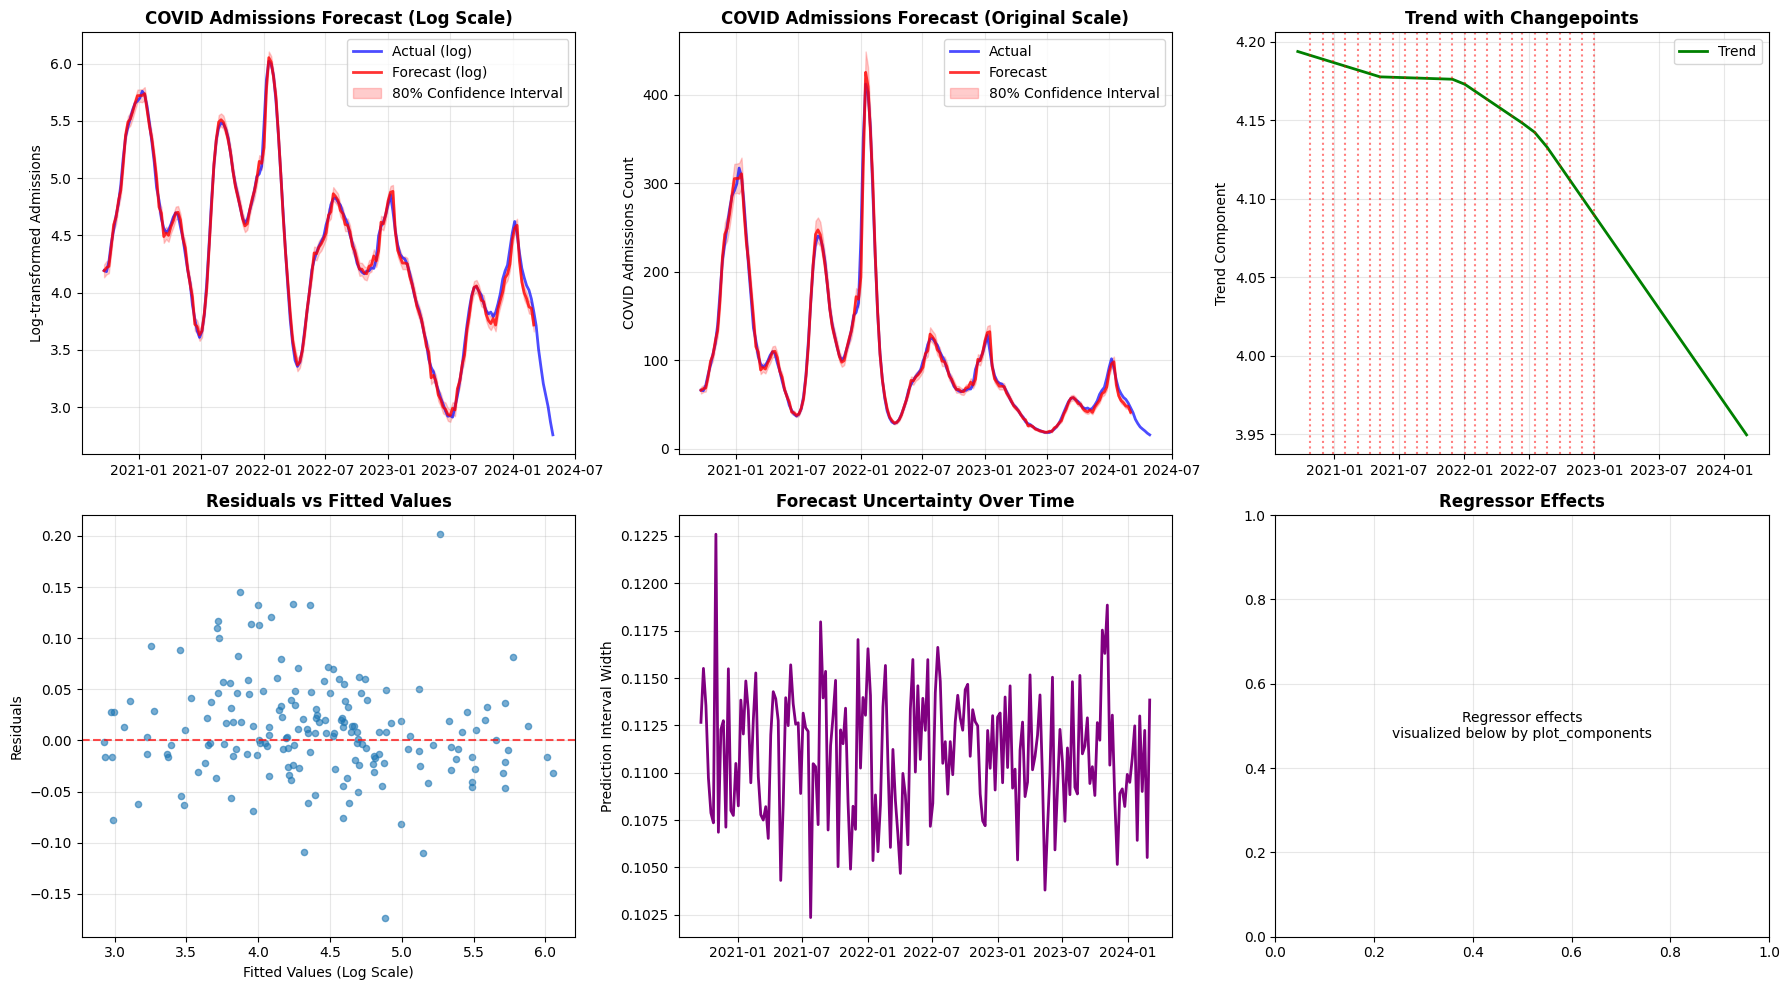

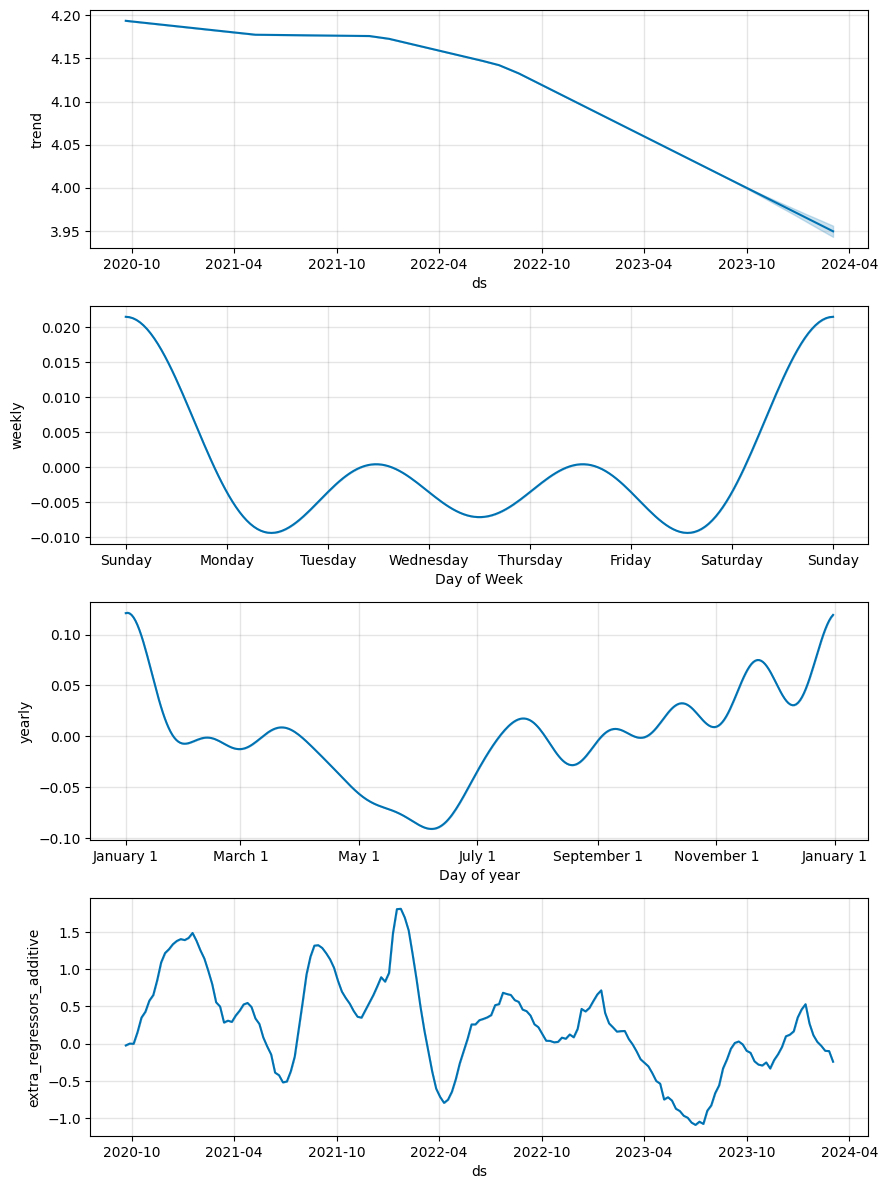


Future Forecasts (Log Scale):
Empty DataFrame
Columns: [ds, yhat, yhat_lower, yhat_upper]
Index: []

Future Forecasts (Original Scale - COVID Admissions):
Empty DataFrame
Columns: [ds, yhat, yhat_lower, yhat_upper]
Index: []


In [25]:
model, forecast, prophet_df, regressors_used = forecast_with_prophet_robust(
    final_modeling_data,
    target_column='average_admissions_all_covid_confirmed',
    forecast_periods=30,
    validation_split=0.8,
    max_regressors=15  # Limit to most stable regressors
)

# Visualize results
plot_robust_forecast_results(
    model, forecast, prophet_df,
    'average_admissions_all_covid_confirmed', regressors_used
)

# Extract future forecasts
future_periods = forecast[len(prophet_df):].copy()
print("\nFuture Forecasts (Log Scale):")
print(future_periods[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))

# Convert to original scale
future_original = future_periods.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    future_original[col] = np.exp(future_original[col])

print("\nFuture Forecasts (Original Scale - COVID Admissions):")
print(future_original[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))


**In both the log-scale and original-scale charts the red forecast line follows the blue actual data quite closely through most of the historical period. This suggests the model has learned the underlying patterns well. The pink shaded area represents the 80% confidence interval, showing the range of uncertainty around the predictions.
The most striking feature is the dramatic decline in the forecast extending into 2024. This isn't just a simple extrapolation - Prophet has identified that the trend fundamentally changed, likely around late 2023 or early 2024, and is projecting that this new downward trend will continue, this may be due to underlying factors like the availability of vaccines or the skepticism of people with the virus and people not going to hospital at all when diagnosed with the corona virus.**

**In the change-point analysis, the red dashed vertical lines mark moments when our algorithm detected significant shifts in the underlying trend. The multiple changepoints throughout the timeline, correspond to different phases of the pandemic - likely including the initial waves, Delta variant surge, Omicron waves, and finally the transition to endemic patterns.
The green trend line shows how the overall direction  evolved from the initial exponential growth phase, through various peaks and valleys, to the current steep decline. This suggests that by the time this forecast was made, COVID hospitalizations had entered a fundamentally different phase - possibly reflecting increased population immunity, better treatments, or seasonal effects.**

***The "Forecast Uncertainty Over Time" plot tells us how our confidence in predictions has evolved throughout the pandemic. The y-axis shows the width of the prediction interval - essentially, how uncertain the model is about its forecasts at any given time.
The uncertainty isn't constant throughout the timeline. In the early period around 2021, we see some of the highest uncertainty spikes. This makes intuitive sense - early in the pandemic, the system was highly volatile and unpredictable. New variants were emerging, policies were changing rapidly, and population behavior was shifting dramatically.
As we move through 2021 and into 2022, the uncertainty generally stabilizes at a lower level, though with periodic spikes. These spikes likely correspond to periods when new information (perhaps new variants or policy changes) made the future more uncertain.The log-scale errors are quite low (0.0683 and 0.0800), which suggests good performance, though the original-scale errors (3.94 and 4.74) remind us that small percentage errors can still translate to meaningful differences in actual case counts.
However, it's crucial to understand that Prophet, like all forecasting models, assumes that future patterns will follow historical relationships. The dramatic downward projection might be accurate if the trend that began in late 2023 continues, but external factors - new variants, waning immunity, policy changes, or seasonal effects - could easily disrupt these predictions.***

##Conclusion
**The main forecast shows COVID-19 respiratory admissions declining dramatically, dropping from hundreds of cases to potentially very low levels by mid-2024. This isn't just a simple downward slope, the  algorithms detected something fundamental changed in the underlying dynamics, likely reflecting the transition from pandemic to endemic patterns. However, the diagnostic plots remind us that this prediction comes with important caveats about confidence and accuracy.The uncertainty analysis shows us that while the model learned stable patterns over most of the pandemic timeline, it became less confident as it projected into this new phase. The residual analysis tells us the model generally captured patterns well, but had some challenges with extreme values. This means we should be particularly cautious about predictions when case levels are very high or very low - exactly the ranges that matter most for emergency planning.tTherefore for immediate planning purposes, health system leaders should prepare for a continued decline in COVID-19 respiratory admissions through 2024. This means they can likely begin reallocating resources that were dedicated to COVID surge capacity toward other healthcare priorities that may have been deferred during the pandemic years. However, this reallocation should be gradual and reversible, not a sudden shift.**
